# Late Fusion: Video Model Interpretation

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
from treeinterpreter import treeinterpreter as ti
from sklearn.model_selection import LeaveOneGroupOut

/usr/local/Caskroom/miniconda/base/envs/kth/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Paths

In [2]:
input_path = '../../../2.data_preparation/out/video/'
output_path = '../out/video/'
# Global configuration path
glob_conf_path = '../../../config/'

### Load global variables

In [3]:
exec(open(os.path.join(glob_conf_path, 'global_config_paper.py')).read())
exec(open(os.path.join(glob_conf_path, 'config_feature_contributions.py')).read())

### Load and shuffle data

In [4]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(input_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,actor_id,file_id,target,group
315,0.021233,0.229774,0.0,0.009934,0.025959,0.025959,0.392857,0.052355,0.300955,0.0,...,0.304999,0.0,0.043796,0.065714,0.065714,0.354839,3,315,9,3
1116,0.039485,0.224748,0.0,0.009934,0.064898,0.064898,0.214286,0.061165,0.328884,0.0,...,0.516488,0.0,0.007299,0.057143,0.057143,0.096774,9,1117,15,4
986,0.019033,0.265832,0.0,0.000000,0.028217,0.028217,0.250000,0.049915,0.312803,0.0,...,0.360287,0.0,0.036496,0.053571,0.053571,0.258065,8,987,14,5
1066,0.136671,0.338577,0.0,0.006623,0.143905,0.143905,0.142857,0.088052,0.428498,0.0,...,0.539384,0.0,0.021898,0.062857,0.062857,0.161290,9,1067,9,4
323,0.017401,0.202495,0.0,0.009934,0.019752,0.019752,0.500000,0.032410,0.326468,0.0,...,0.384070,0.0,0.014599,0.054286,0.054286,0.354839,3,323,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.069223,0.248553,0.0,0.009934,0.104402,0.104402,0.178571,0.094007,0.345926,0.0,...,0.468963,0.0,0.007299,0.045714,0.045714,0.161290,2,141,3,1
1048,0.110931,0.292778,0.0,0.004967,0.158014,0.158014,0.107143,0.121789,0.438431,0.0,...,0.380418,0.0,0.000000,0.318571,0.318571,0.129032,9,1049,6,4
752,0.035854,0.240812,0.0,0.013245,0.057562,0.057562,0.357143,0.037980,0.259521,0.0,...,0.272443,0.0,0.051095,0.046429,0.046429,0.354839,6,753,17,2
543,0.138369,0.282866,0.0,0.019868,0.224605,0.224605,0.357143,0.143821,0.367985,0.0,...,0.355894,0.0,0.036496,0.102143,0.102143,0.483871,5,543,6,3


## Model interpretation

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())

# Load best parameters and initialize classifier
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
clf = RandomForestClassifier(**best_params)

# Perform LOGO CV (5 GROUPS)
data_tmp = [] # Initialize to store data
logo = LeaveOneGroupOut()
for train_idx, val_idx in logo.split(X, y, groups):
    X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
    
    # Fit models
    clf.fit(X_train, y_train)
    
    # Step 0. Get prediction probabilities, bias, contributions, predicted class and store it in a DataFrame
    prediction_proba, bias, contributions = ti.predict(clf, X_val)
    prediction = clf.predict(X_val)
    for i in range(len(X_val)):
        pred_class_tmp = prediction[i]
        bias_tmp = bias[i, pred_class_tmp]
        contributions_tmp = contributions[i, :, pred_class_tmp]
        data_tmp.append([bias_tmp] + contributions_tmp.tolist() + [pred_class_tmp])

interpretation_step_0_df = pd.DataFrame(data=data_tmp, columns=['bias']+X.columns.tolist()+['prediction'])
interpretation_step_0_df

,bias,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU26_r_iqr60_80-20,AU26_r_numPeaks,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,prediction
0,0.054793,-0.003109,0.001387,0.000000,-0.002284,0.000786,-0.000075,0.001396,0.000648,0.000834,...,-0.000148,0.000211,-0.001453,0.002167,0.0000,-0.000984,0.000449,-0.001375,0.000943,2
1,0.055636,0.004373,0.003896,0.000000,0.001211,0.002116,0.003476,0.003804,0.006861,0.001578,...,0.000525,0.000741,0.002871,0.007009,0.0000,0.004679,0.002056,0.000148,-0.001739,17
2,0.055636,-0.006186,0.002101,0.000000,-0.000870,-0.002814,-0.003464,-0.000406,0.005217,0.000803,...,-0.004237,-0.000814,0.000872,0.002916,0.0000,0.001617,-0.000198,-0.000110,0.000179,17
3,0.055760,0.001285,0.000997,0.000000,-0.000780,0.001530,0.001963,-0.000658,0.003080,-0.000787,...,0.000625,0.000600,-0.000286,0.000882,0.0001,0.002136,0.000120,-0.000308,0.000854,6
4,0.056045,0.002106,0.000958,0.000000,0.001719,0.002485,0.001232,-0.000707,0.001190,0.003694,...,-0.000640,0.000425,0.000011,-0.000797,0.0000,0.002295,-0.001313,-0.001460,0.000341,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.055387,0.005683,-0.003772,0.000000,-0.003693,0.001061,0.002744,0.001715,0.000705,0.000674,...,0.000402,0.000533,0.003658,0.004273,0.0000,0.000161,0.000553,0.003746,-0.000006,17
1255,0.055387,0.005502,0.001947,0.000000,-0.003772,0.001617,0.001922,0.001900,0.000192,0.004314,...,0.001295,0.001367,0.004586,-0.002578,0.0000,0.000118,-0.000090,0.001811,-0.002969,17
1256,0.055150,0.002194,0.001577,0.000000,-0.002207,0.002722,0.000377,-0.005206,0.001515,0.009538,...,0.005165,0.002169,0.015897,-0.008562,0.0000,-0.000152,0.001152,0.003804,-0.000428,16
1257,0.055096,0.001287,-0.000410,0.000003,0.002340,0.001278,-0.000347,-0.001852,0.006738,-0.002943,...,-0.001207,0.003055,-0.000412,-0.001151,0.0000,-0.003587,-0.000233,0.000009,0.000035,7


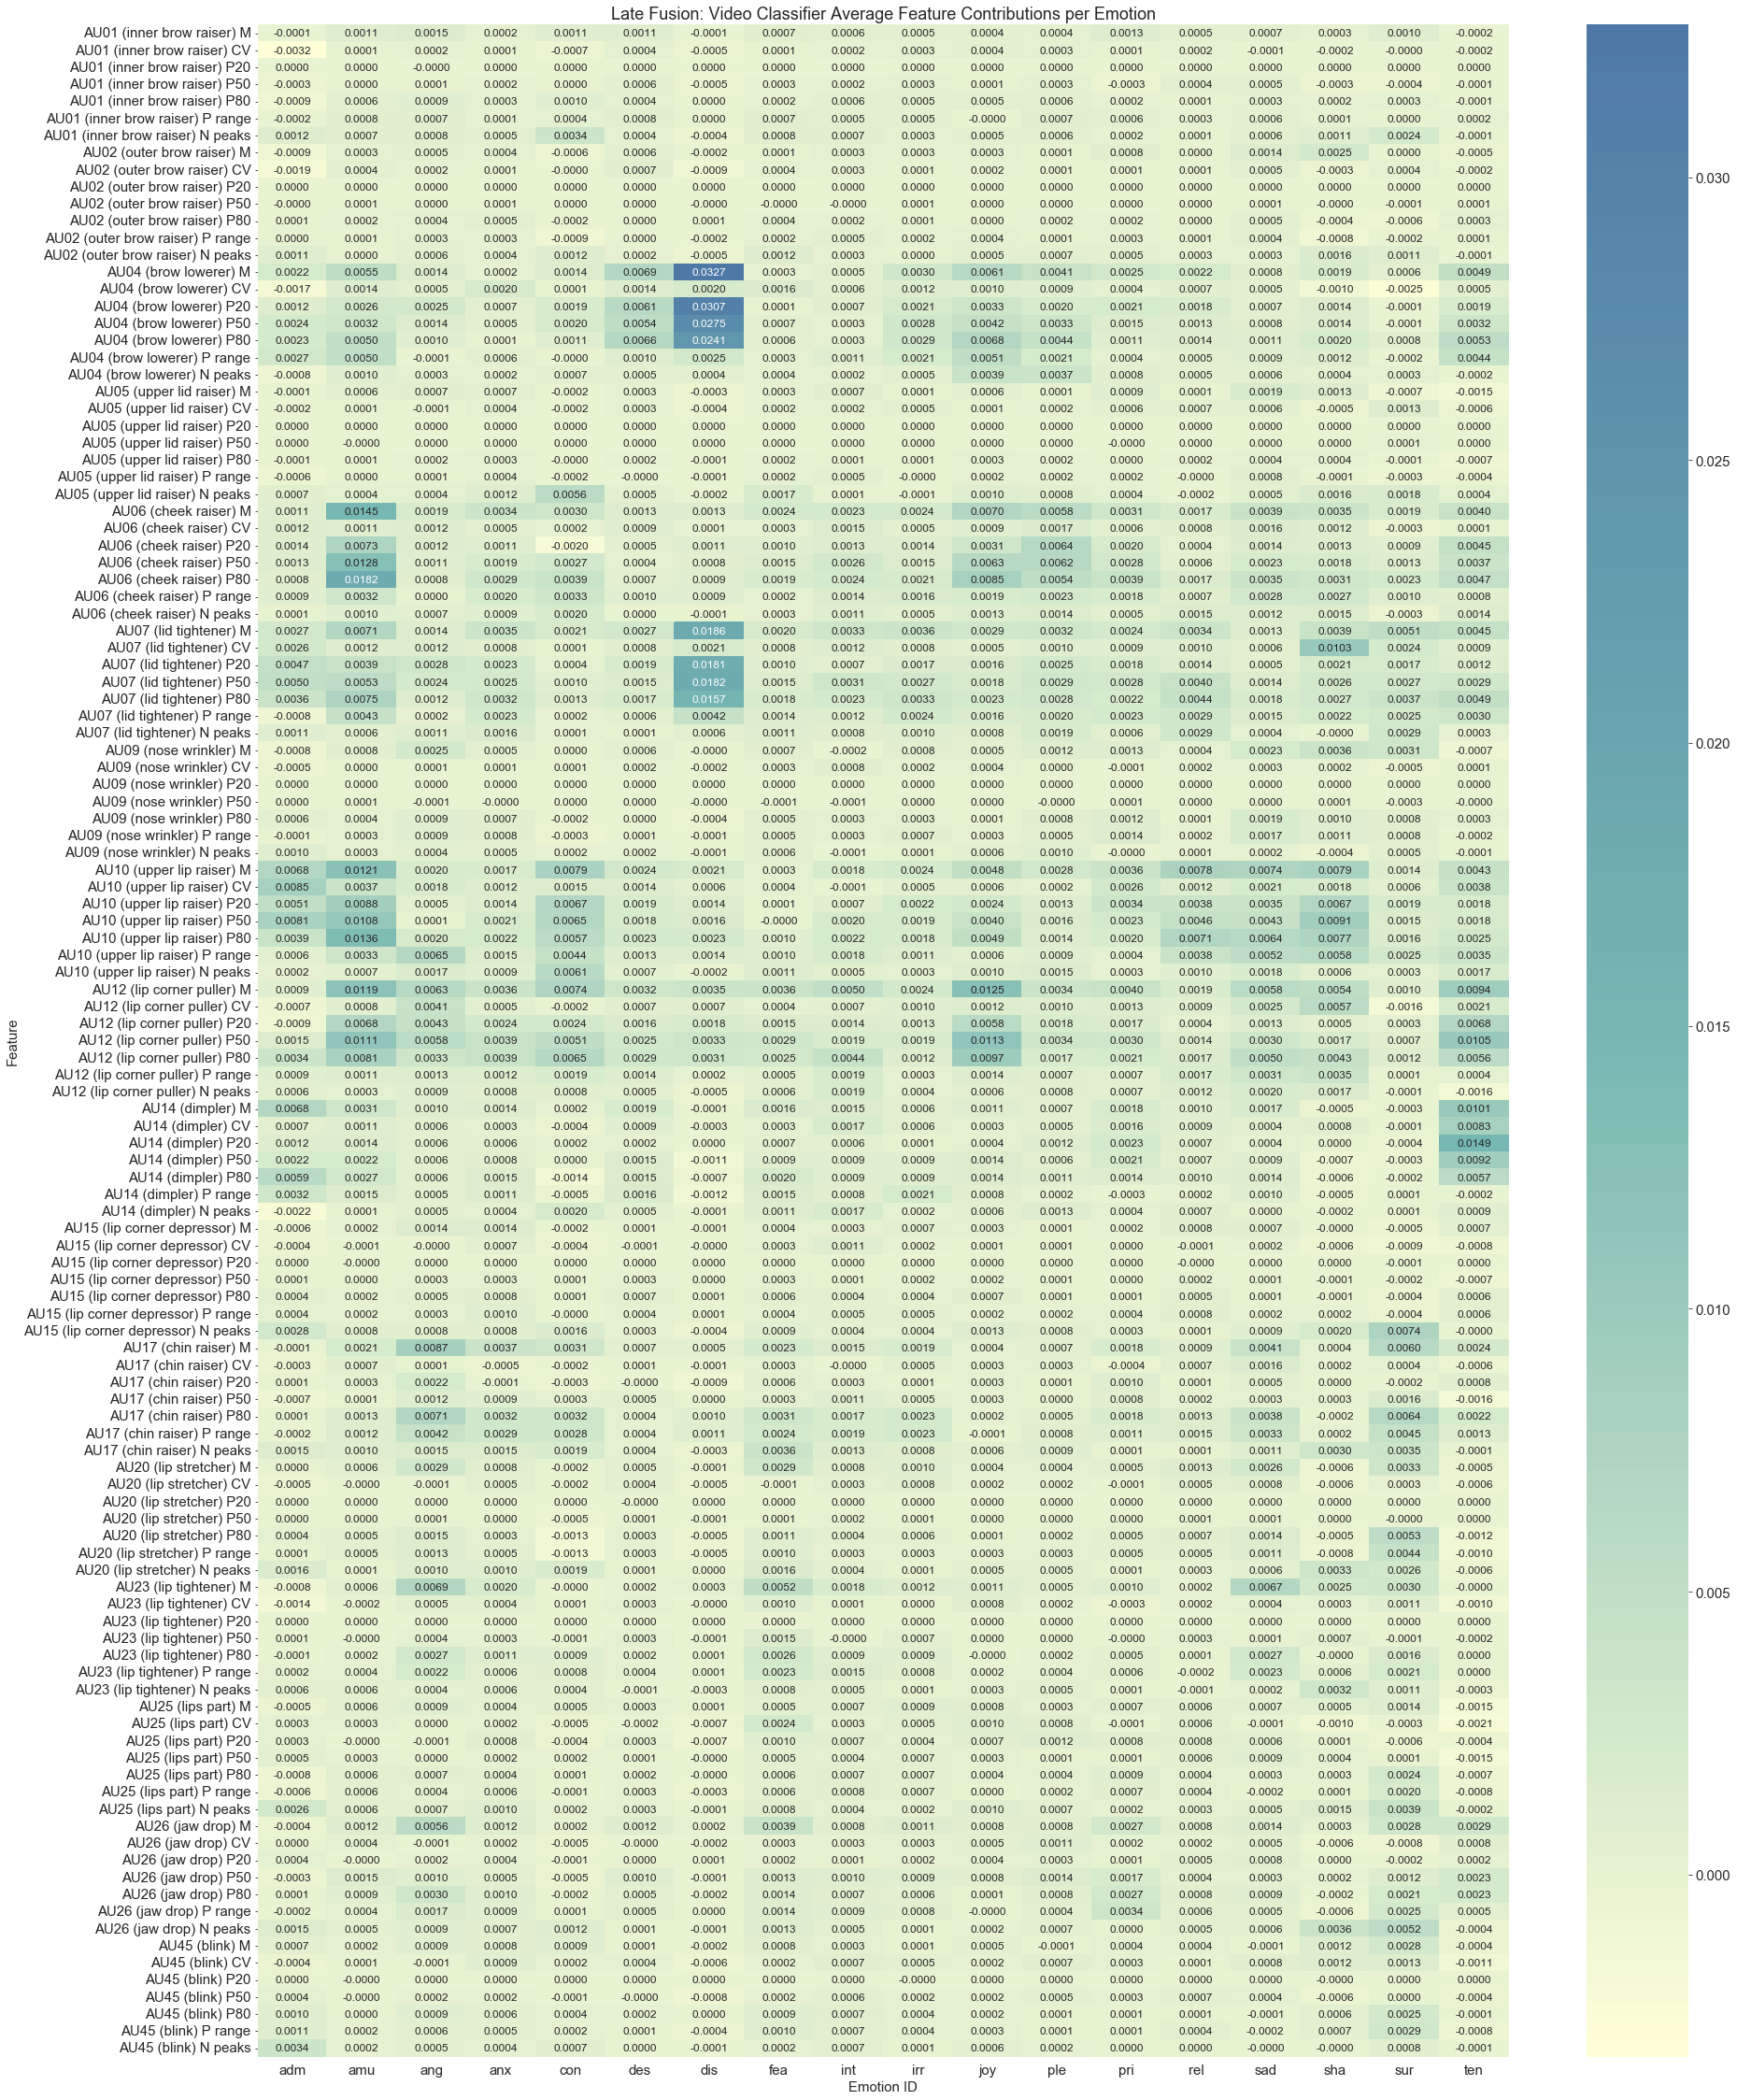

In [6]:
# Step 1. Group by predicted class and calculate mean
interpretation_step_1_df = interpretation_step_0_df.groupby('prediction').mean().reset_index()
interpretation_step_1_df['emotion_id'] = interpretation_step_1_df['prediction'].map(emotion_num_to_emotion_eng_id)
interpretation_step_1_df = interpretation_step_1_df.drop(columns='prediction')

#interpretation_step_1_df

# Plot results
sns.set_style({'ytick.left': True})
mat = interpretation_step_1_df.drop(columns='bias').set_index(keys='emotion_id').transpose()
mat = mat.reindex(sorted(mat.columns), axis=1)
mat = mat.rename(var_name_to_feat, axis=0)
mat = mat.reindex(list(var_name_to_feat.values())).dropna()
mat.to_csv(os.path.join(output_path,'others','tmp','video_classifier_feature_contributions.csv'), index=True, header=True)

plt.figure(figsize=(30,40))
ax = sns.heatmap(mat, annot=True, annot_kws={"size": 12}, fmt='.4f', cmap=conf_cmap)
plt.yticks(va='center')
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
plt.savefig(os.path.join(output_path,'others','report_video_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.title('Late Fusion: Video Classifier Average Feature Contributions per Emotion')
plt.savefig(os.path.join(output_path,'others','video_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.show()
sns.set_style({'ytick.left': False})


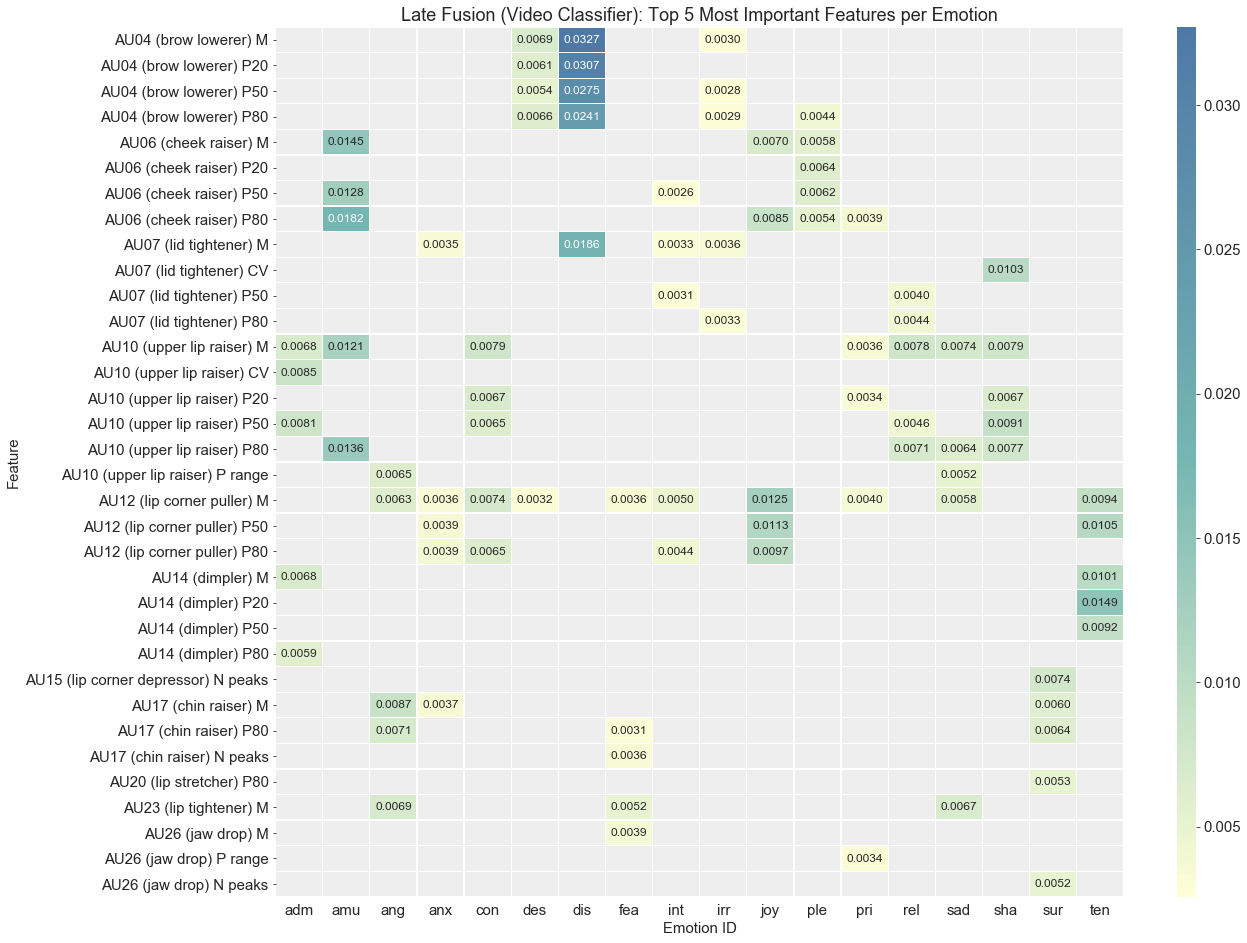

In [7]:
data = mat.copy()
data_abs = data.abs()
top_features_per_emotion = {}
n = 5
for c in data.columns:
    top_features_per_emotion[c] = data_abs.nlargest(n, columns=c).index.tolist()

#all_features = set(data.index.tolist())
features_to_keep = set([item for sublist in top_features_per_emotion.values() for item in sublist])
#features_to_drop = all_features - features_to_keep

data_reduced = data.loc[features_to_keep].reindex(data.index).dropna()
data_reduced = data_reduced.reindex(feat_order_summary_video)
mask = np.array([[feat not in top_features_per_emotion[c] for feat in data_reduced.index] for c in data_reduced.columns]).T
data_reduced.mask(mask).to_csv(os.path.join(output_path,'others','tmp','video_classifier_feature_contributions_top_'+str(n)+'.csv'), index=True, header=True)


# Plot results
sns.set_style({'ytick.left': True})
plt.figure(figsize=(19,16))
hm = sns.heatmap(data_reduced, annot=True, annot_kws={"size": 12}, fmt='.4f', cmap=conf_cmap, cbar_kws={"aspect": 45}, linewidth=0.25, mask=mask)
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
ax = hm.axes
ax.set_facecolor((238/255, 238/255, 238/255))
plt.savefig(os.path.join(output_path,'others','report_video_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.title('Late Fusion (Video Classifier): Top ' + str(n) + ' Most Important Features per Emotion')
plt.savefig(os.path.join(output_path,'others','video_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.show()

sns.set_style({'ytick.left': False})